In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("amp_curves.csv")
print(df.head())
df_array = df.iloc[:,1:].to_numpy(dtype=float)
molnames = df.iloc[:,0].to_numpy(dtype=str)

       mol  A1_5   A1_10   A1_20   A1_40   A1_80  A2_5   A2_10   A2_20  \
0  1500272   NaN   11.53   28.20   40.37   64.35   NaN   13.25   29.46   
1  1501007   NaN   11.48   18.07   47.45   92.83   NaN   14.31   23.01   
2  1501150   NaN   49.44  113.83  152.94  200.30   NaN   40.09   79.97   
3  1503100   NaN  133.16  235.08  393.65  825.84   NaN  124.53  232.97   
4  1503243   NaN   92.55  168.76  301.06  652.52   NaN  106.38  200.59   

    A2_40  ...  A1_pd3pore_5  A1_pd3pore_10  A1_pd3pore_20  A1_pd3pore_40  \
0   34.31  ...           NaN          33.51          52.89          68.61   
1   62.53  ...           NaN          19.81          30.80          88.92   
2  118.30  ...           NaN          55.31          71.02         160.54   
3  412.39  ...           NaN         110.70         190.48         401.47   
4  336.07  ...           NaN         226.22         376.49         609.41   

   A1_pd3pore_80  A2_pd3pore_5  A2_pd3pore_10  A2_pd3pore_20  A2_pd3pore_40  \
0         127

In [3]:
from sklearn.linear_model import LinearRegression

def scale(val):
    # scale extreme data points
    scale_zone = (2,17) # scale values between 2 to 17
    compress_ratio = 0.5 # scale the zone into 0.5
    if val > scale_zone[1]:
        raise ValueError(f"value larger than maximum: {val} > {scale_zone[1]}")
    elif val > scale_zone[0]:
        return scale_zone[0] + 1.5 * (val-scale_zone[0])/(scale_zone[1]-scale_zone[0])
    else:
        return val


def CalcSlope(X, Y):
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]
    X = X.reshape(-1,1)
    reg = LinearRegression(fit_intercept=False).fit(X, Y)
    return np.round(reg.coef_[0],3), np.round(reg.score(X,Y),3) # slope, r2

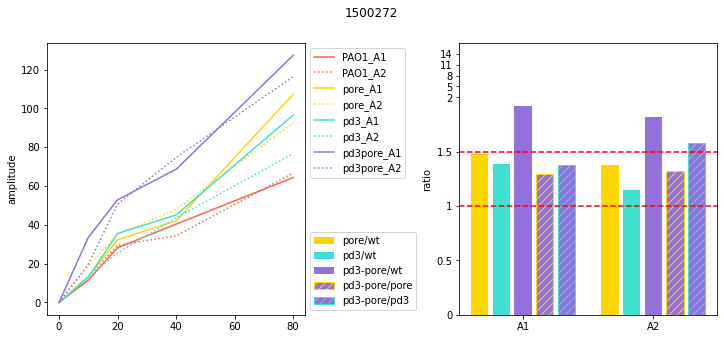

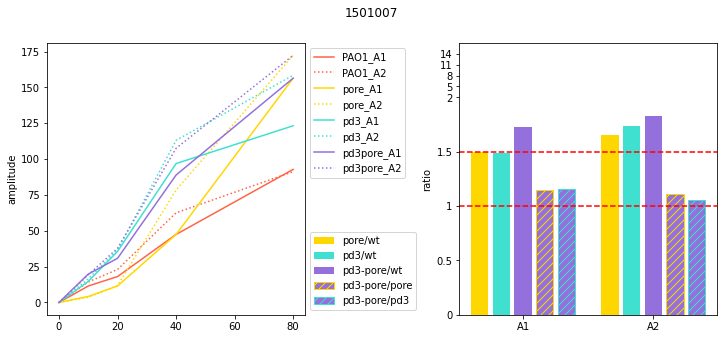

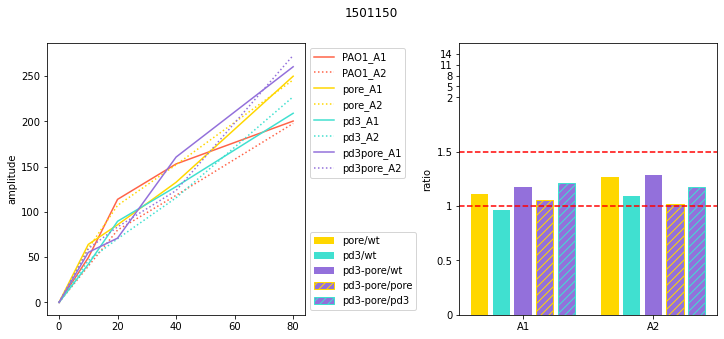

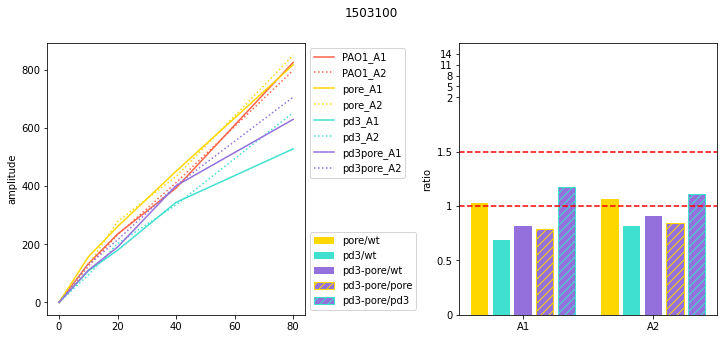

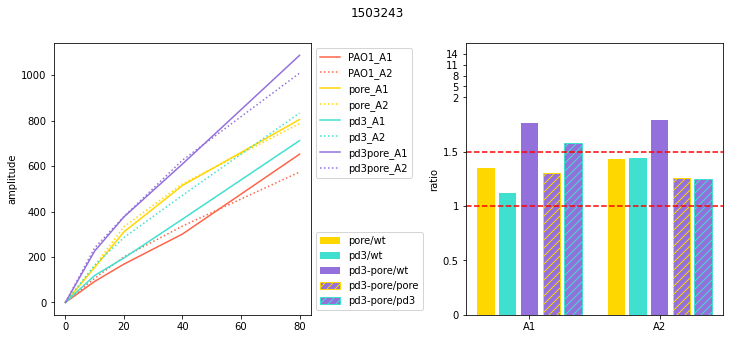

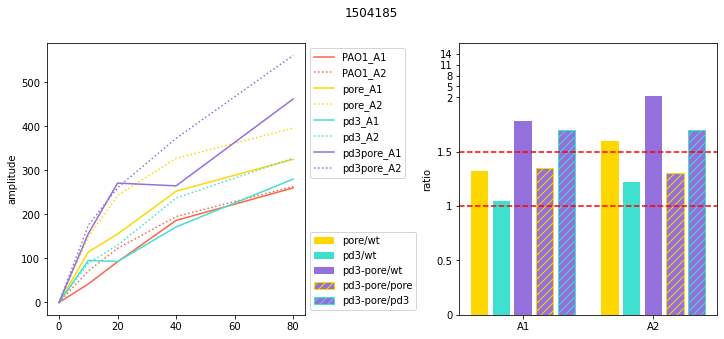

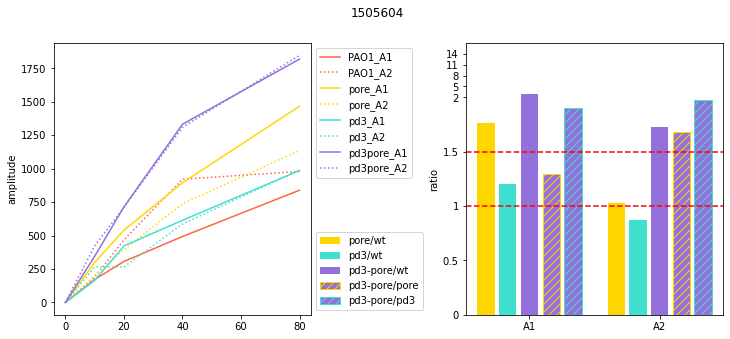

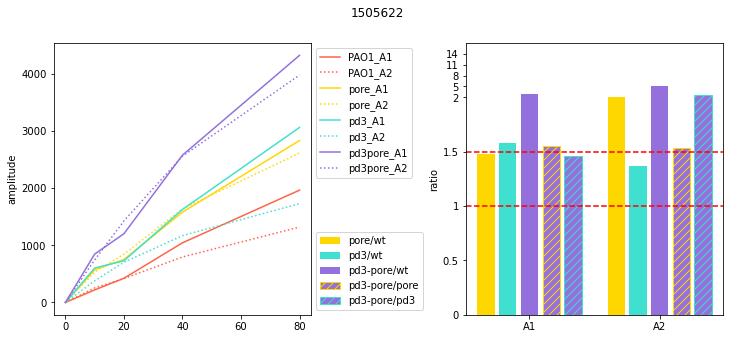

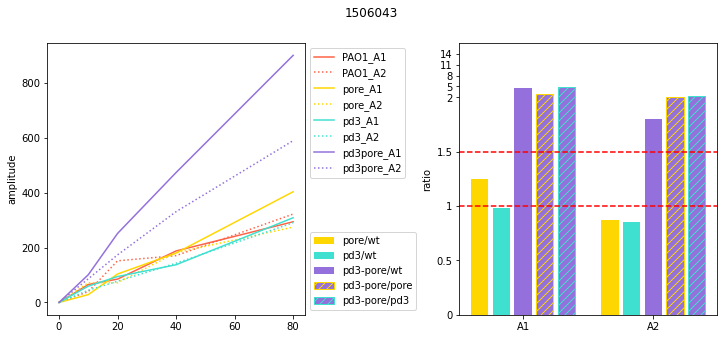

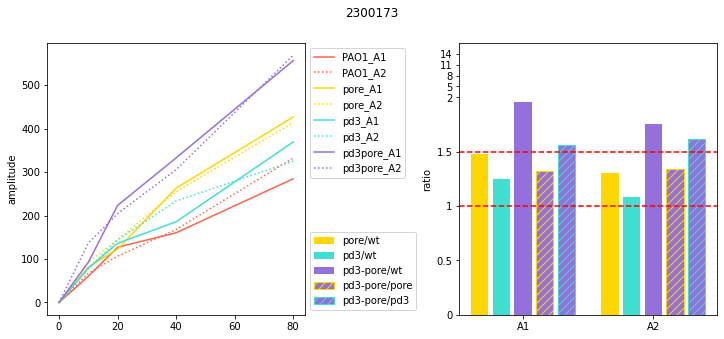

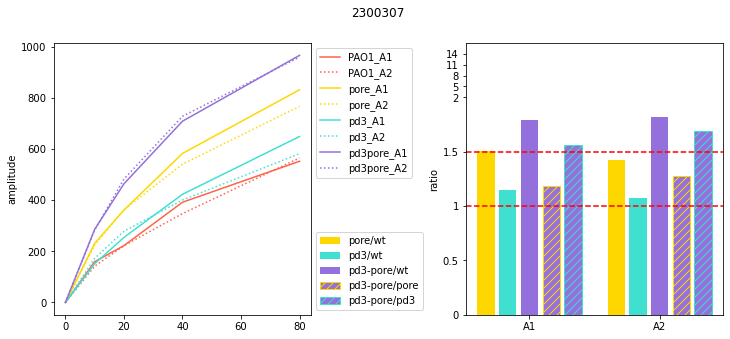

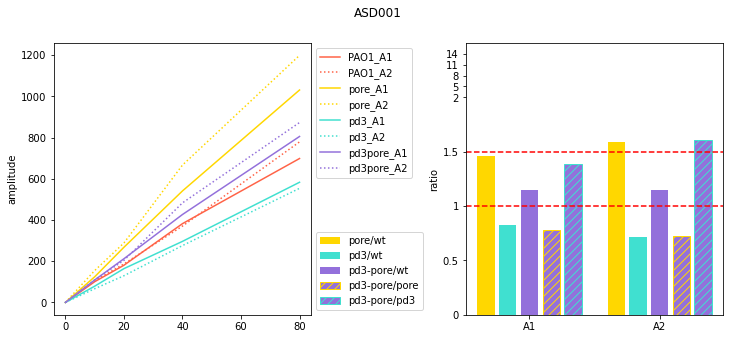

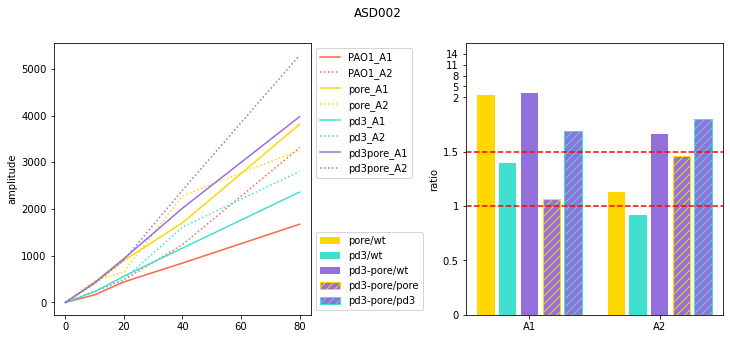

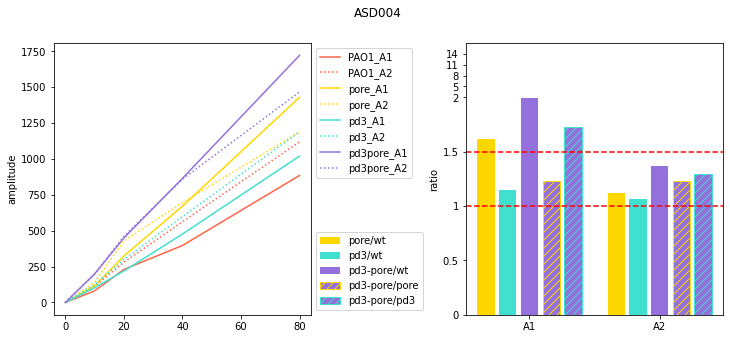

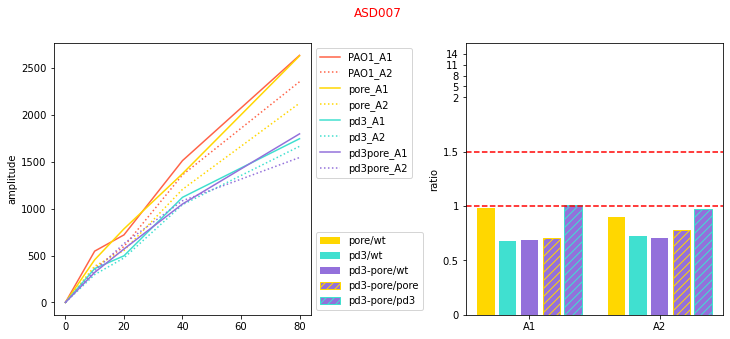

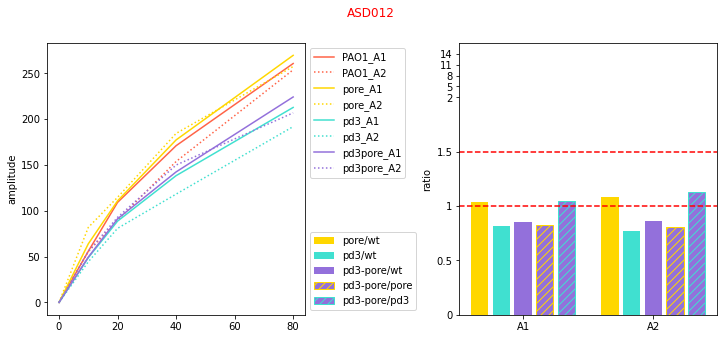

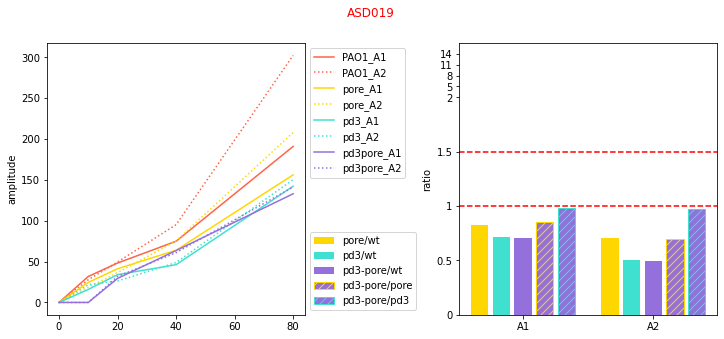

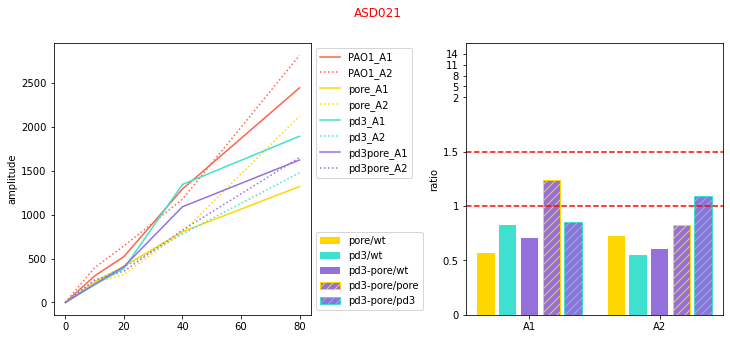

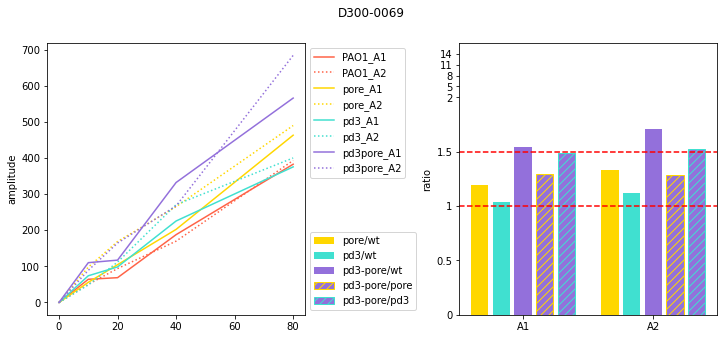

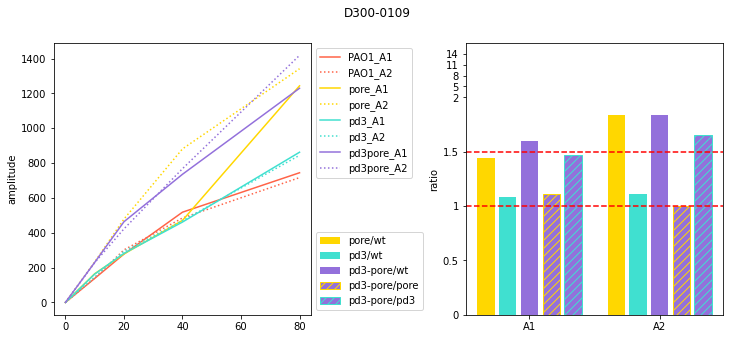

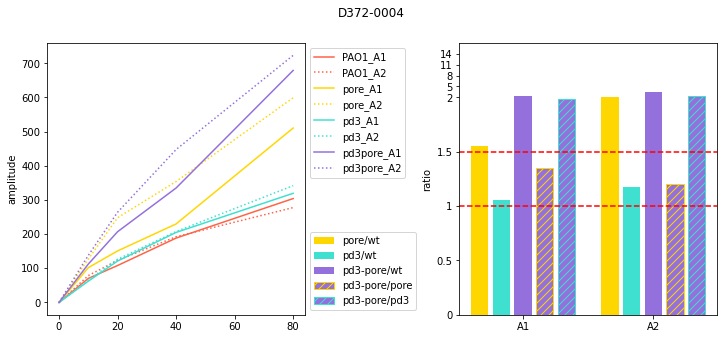

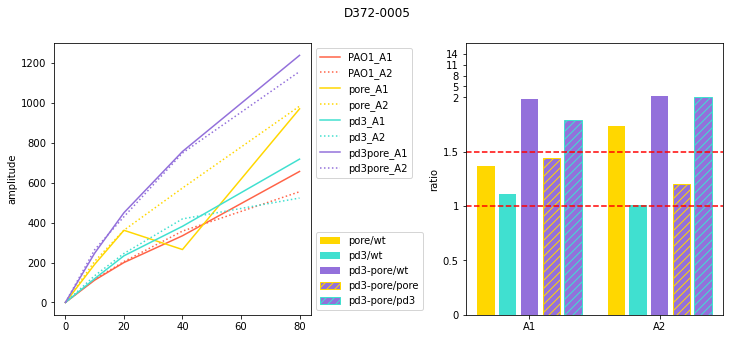

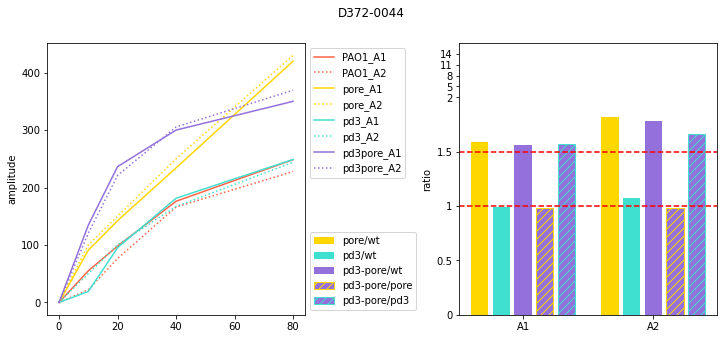

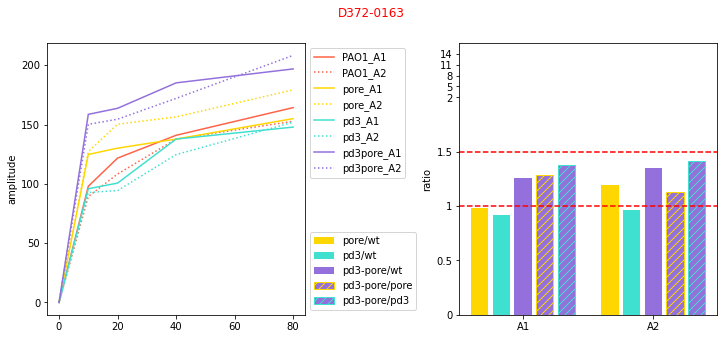

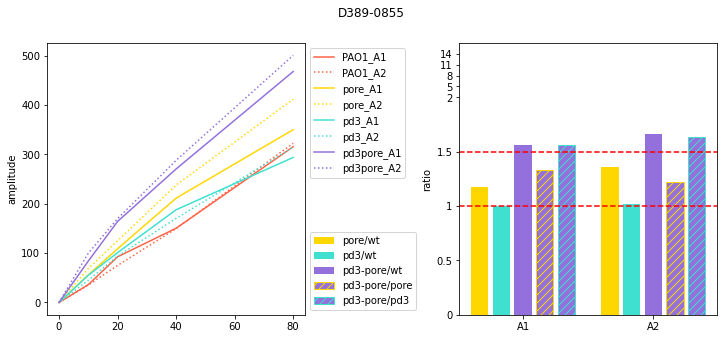

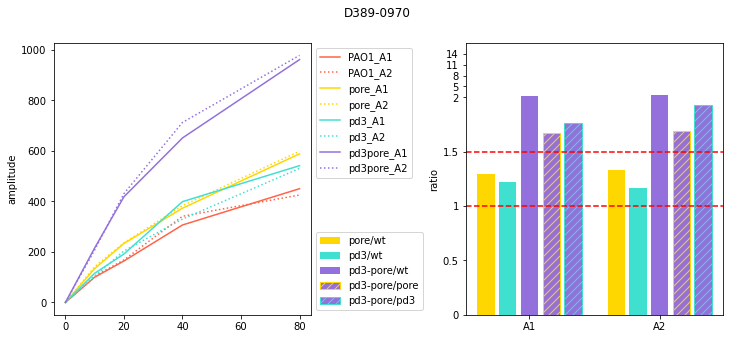

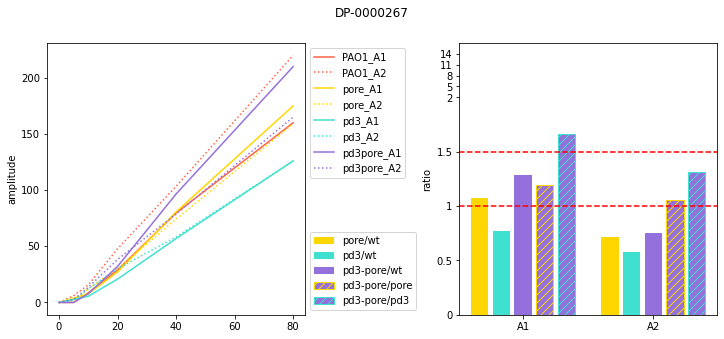

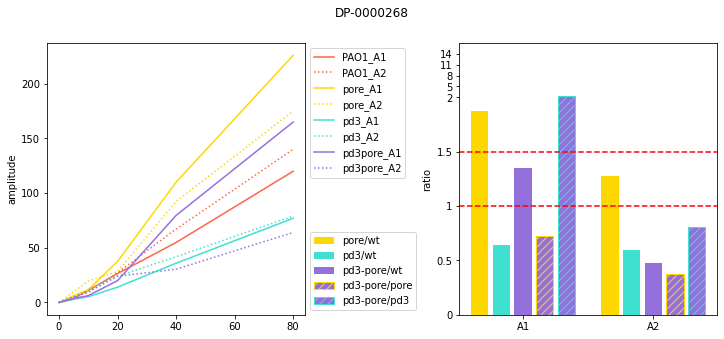

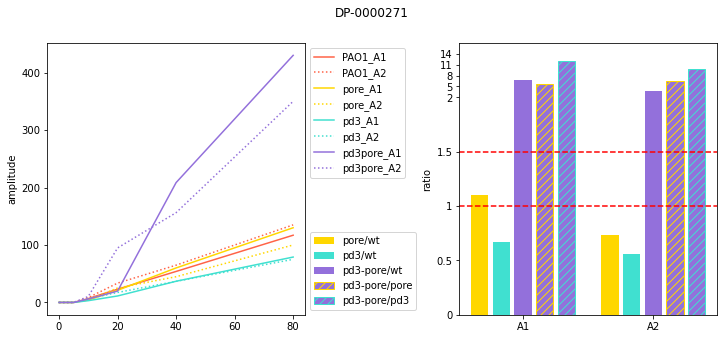

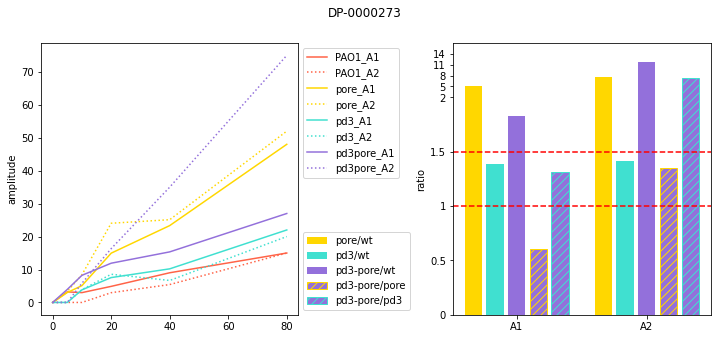

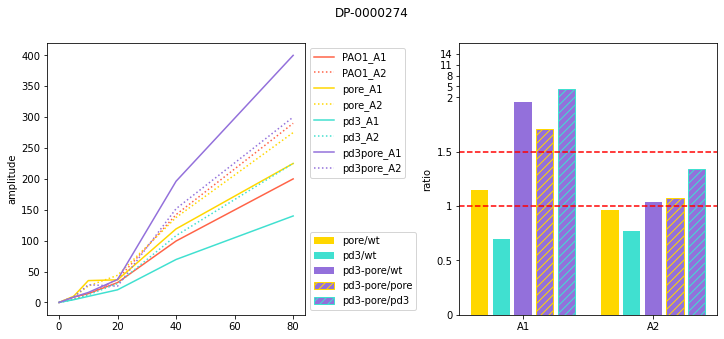

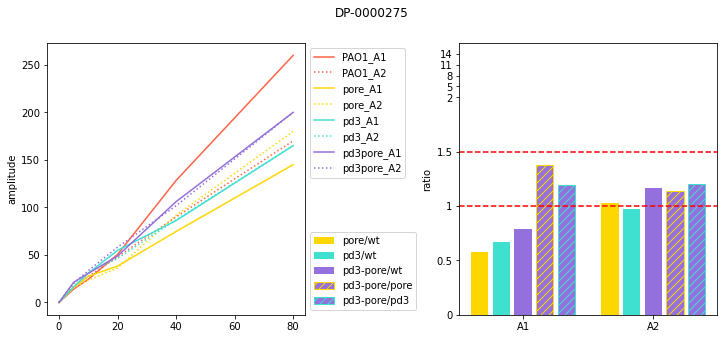

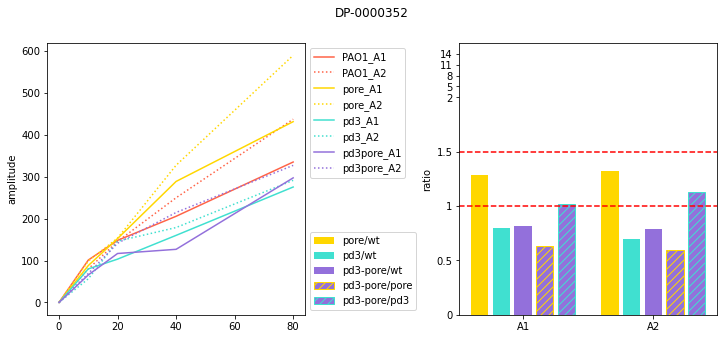

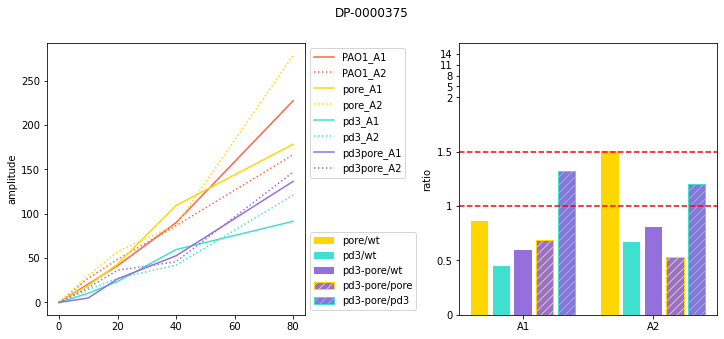

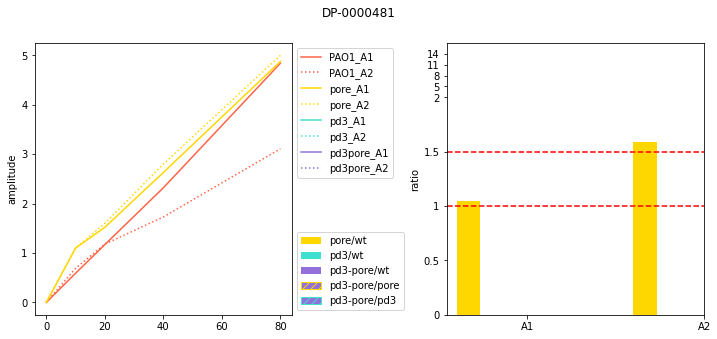

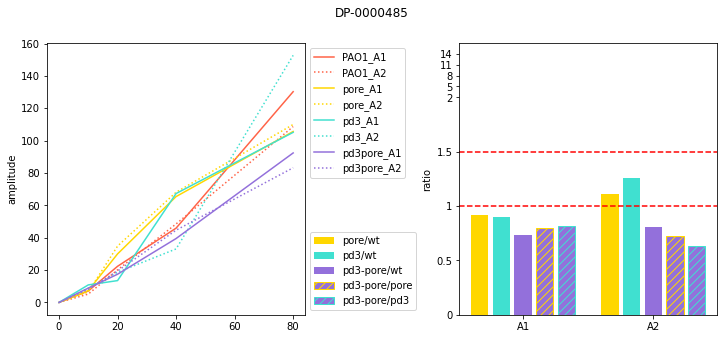

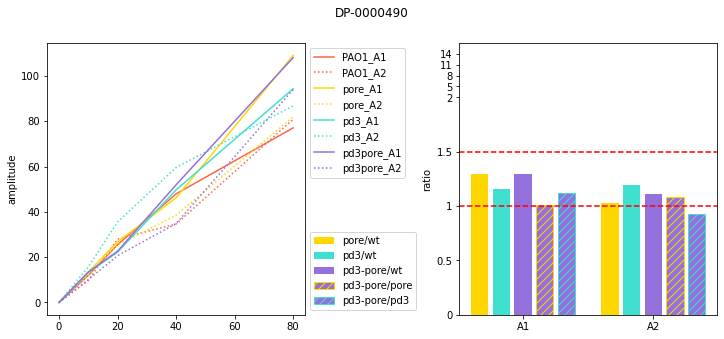

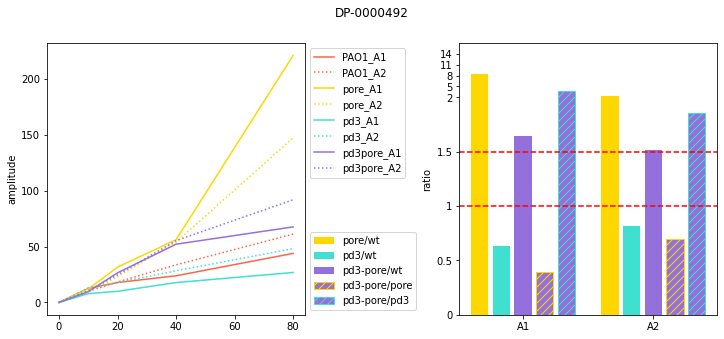

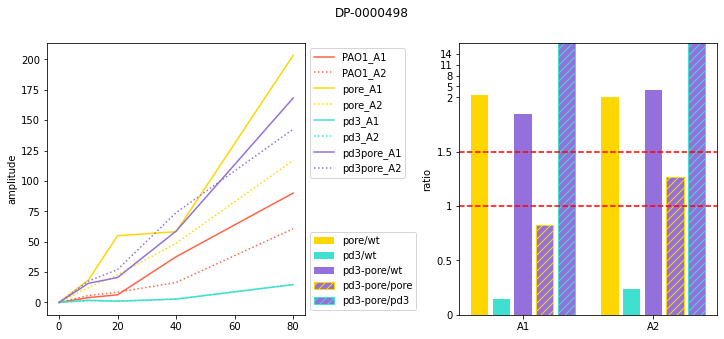

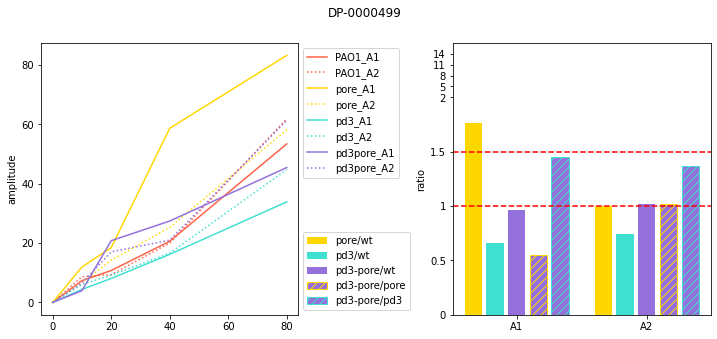

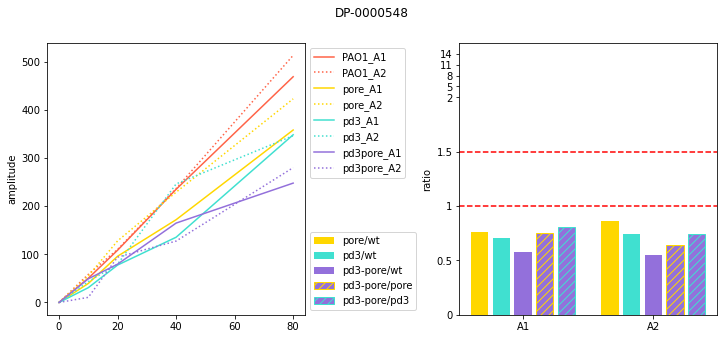

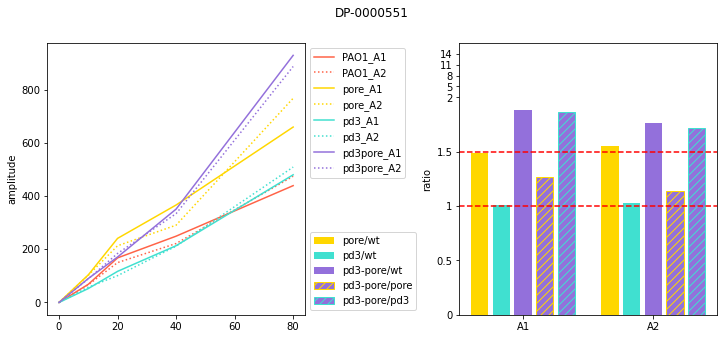

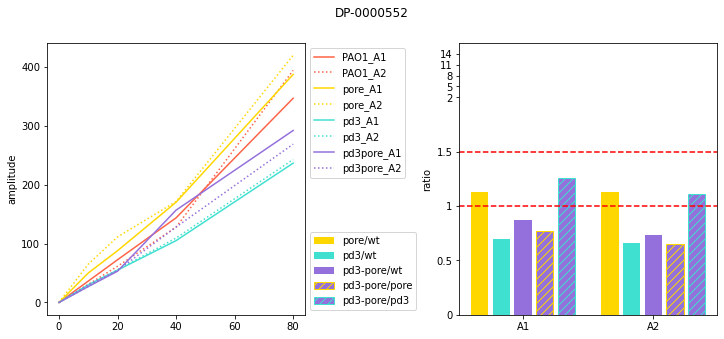

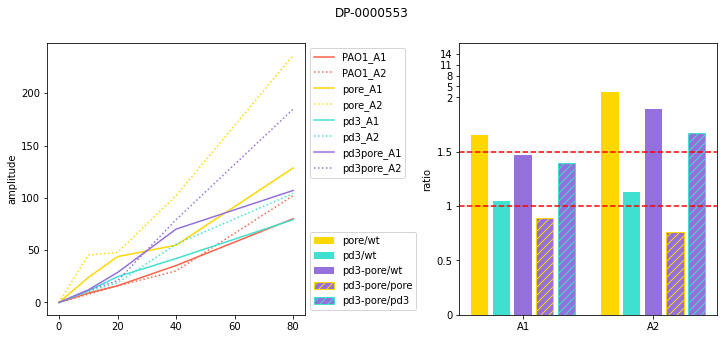

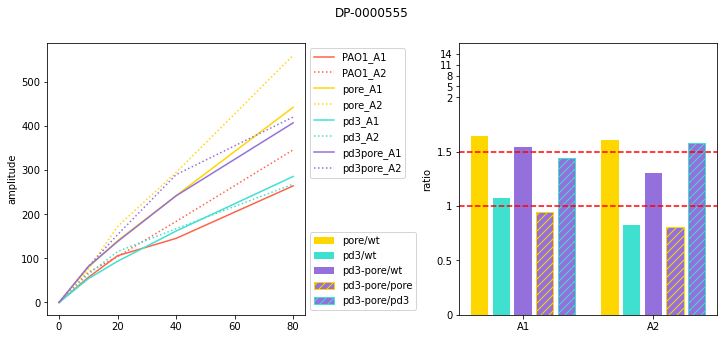

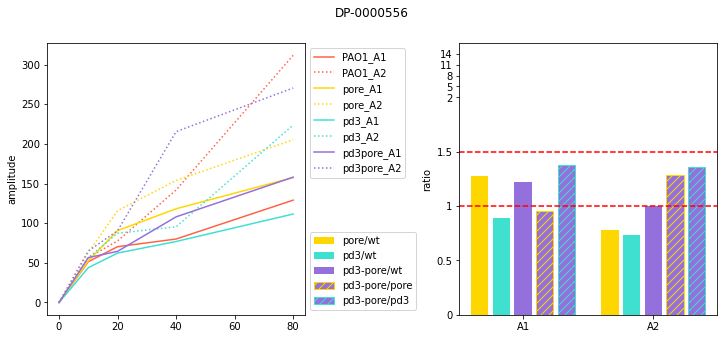

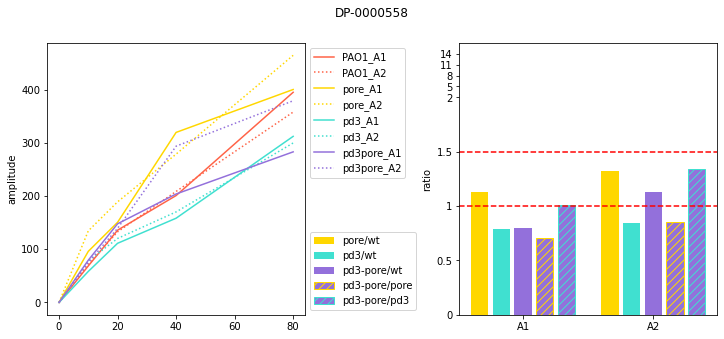

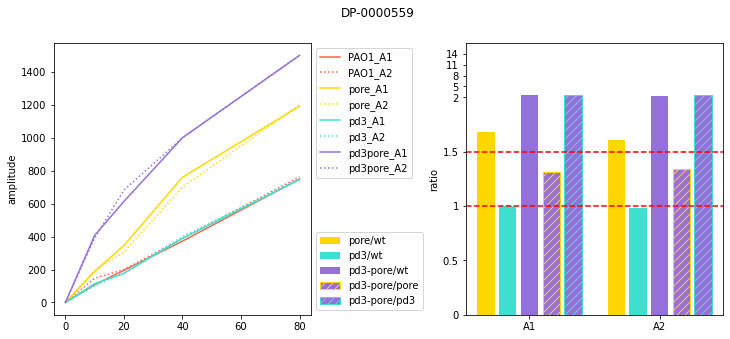

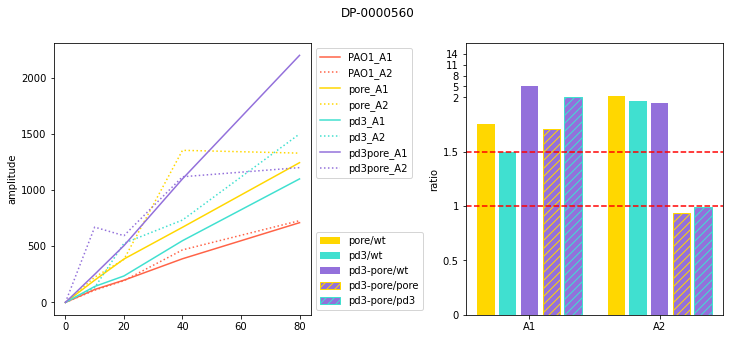

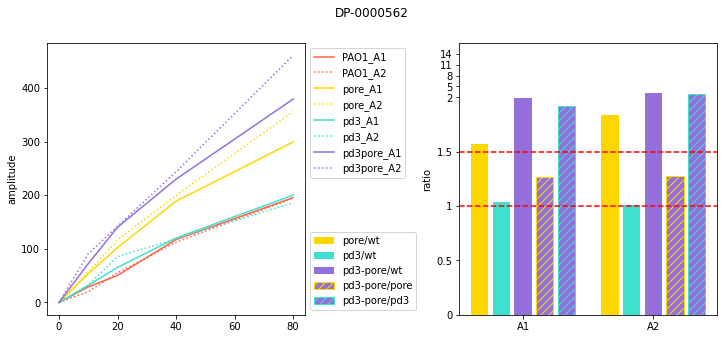

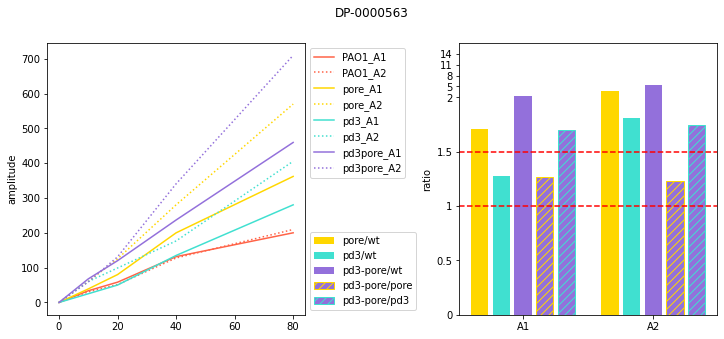

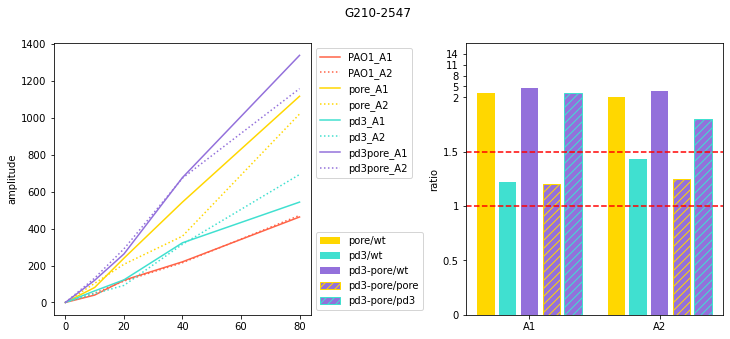

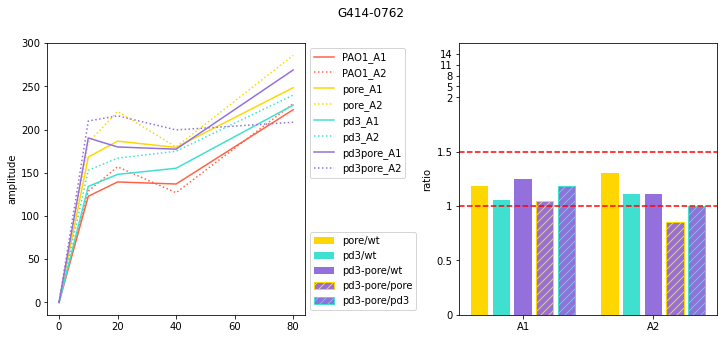

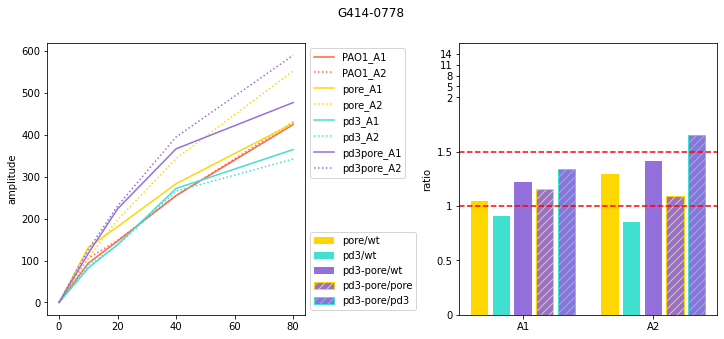

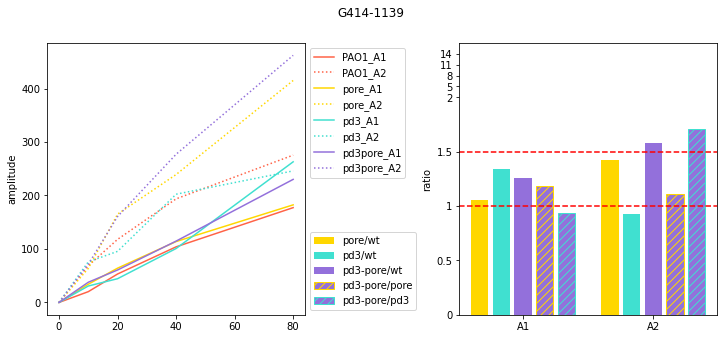

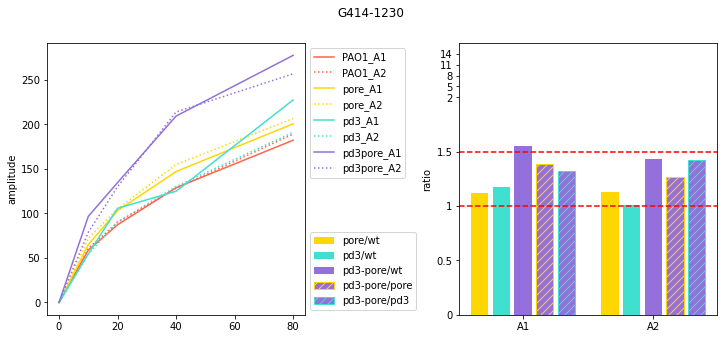

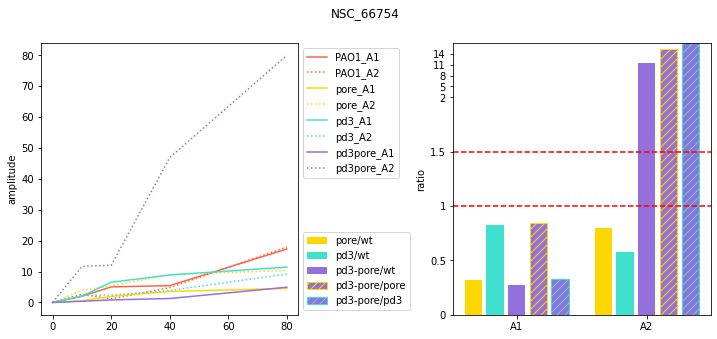

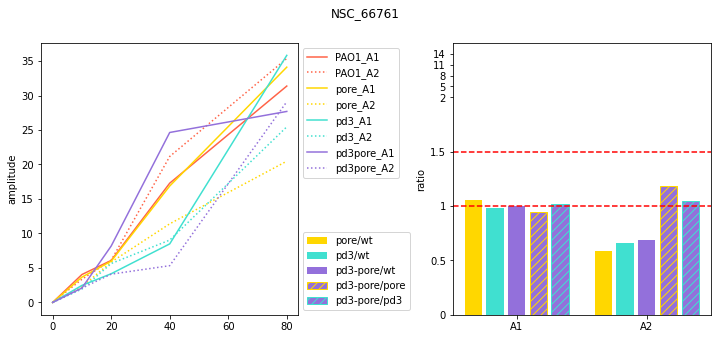

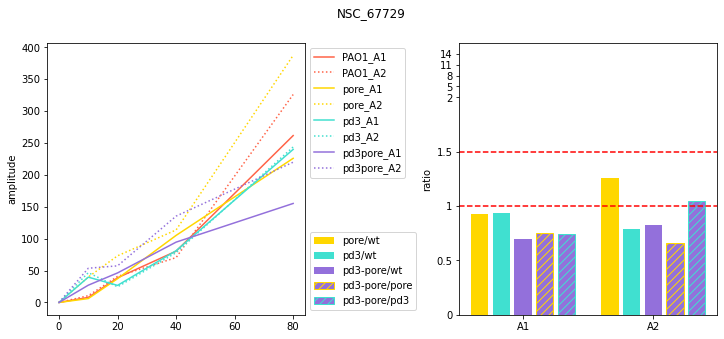

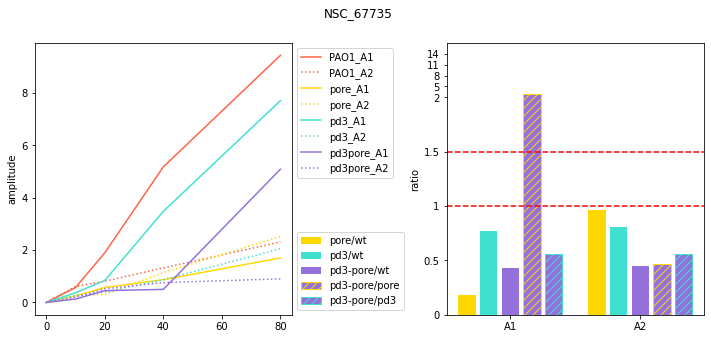

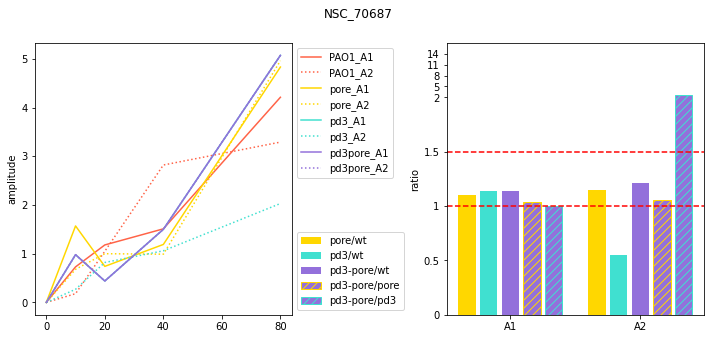

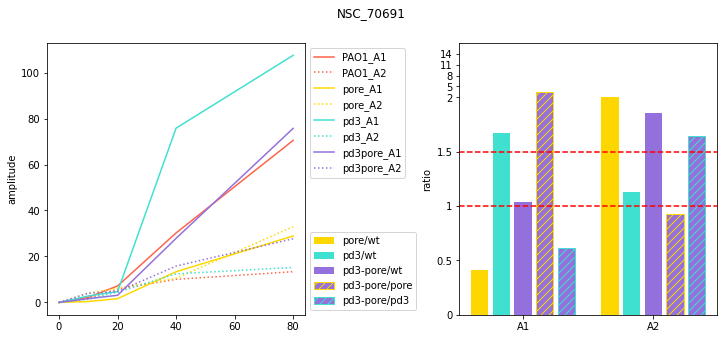

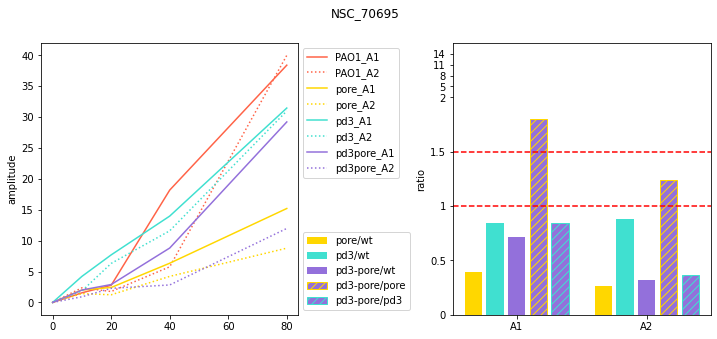

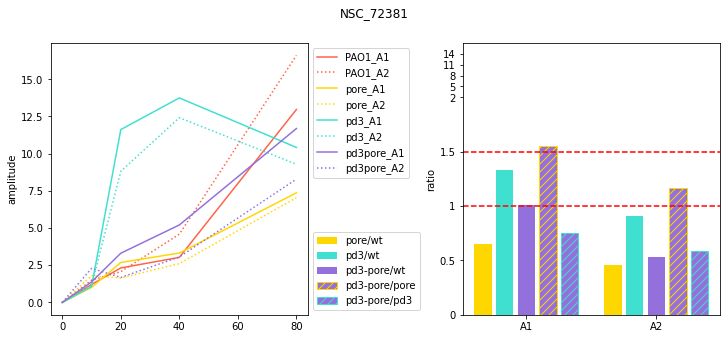

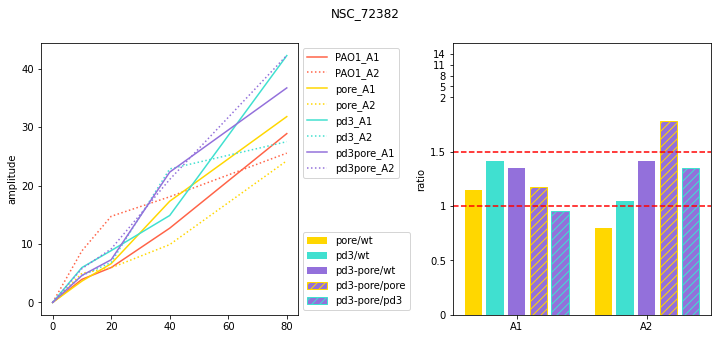

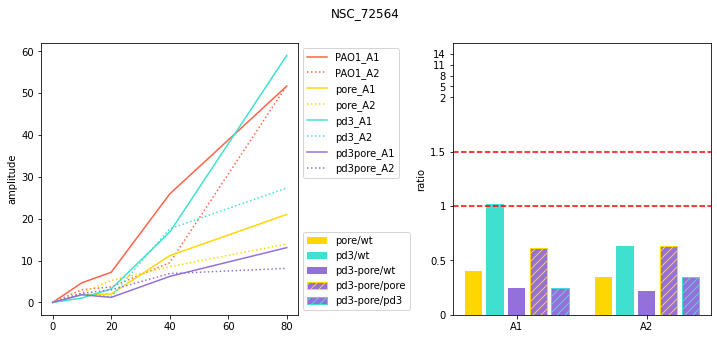

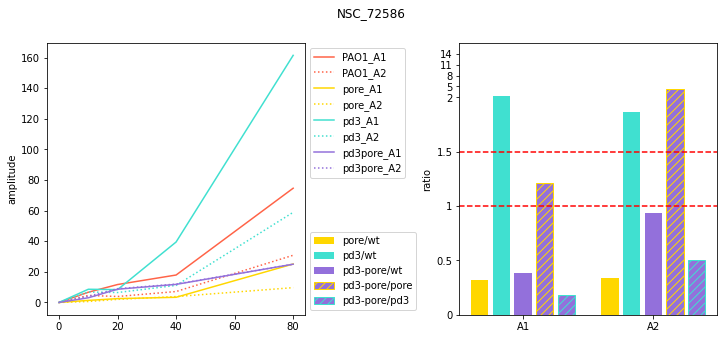

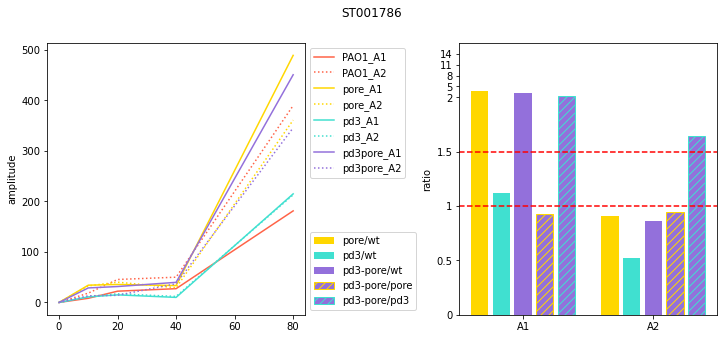

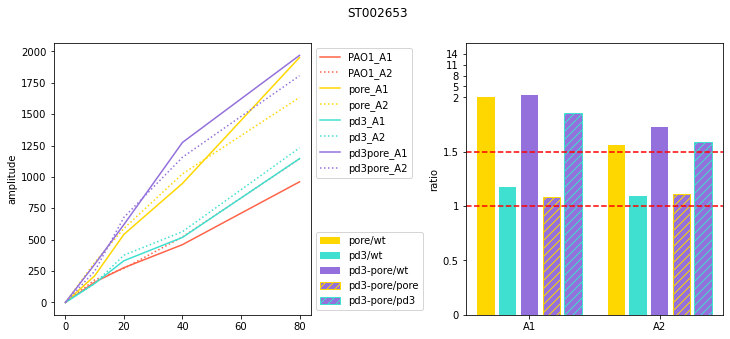

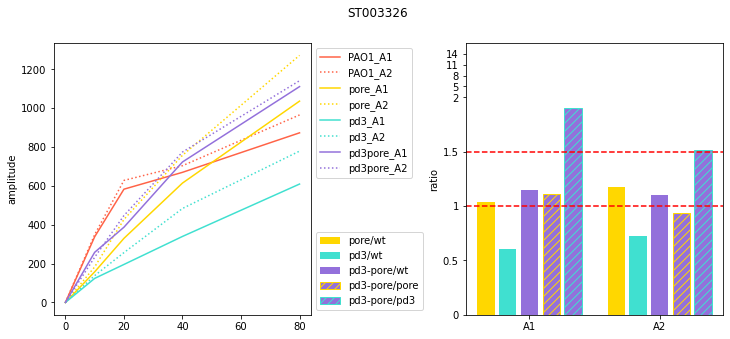

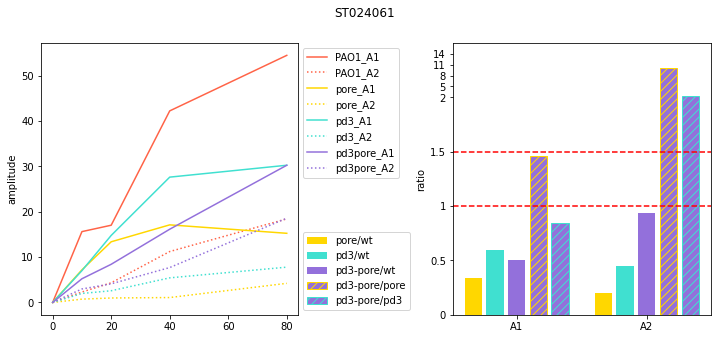

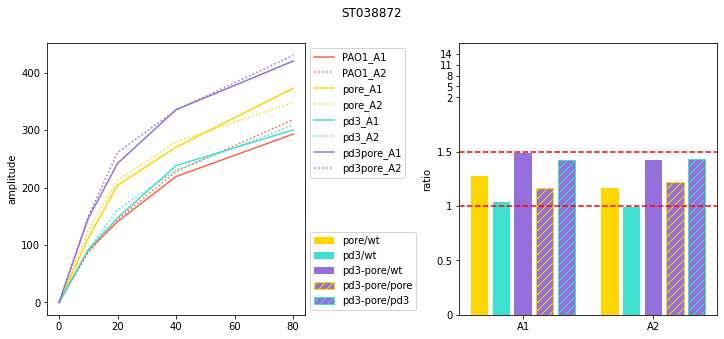

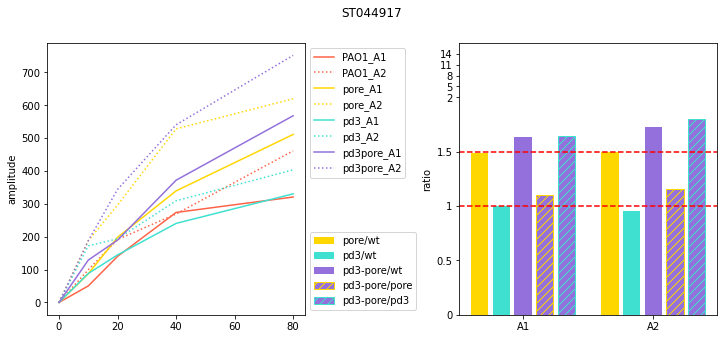

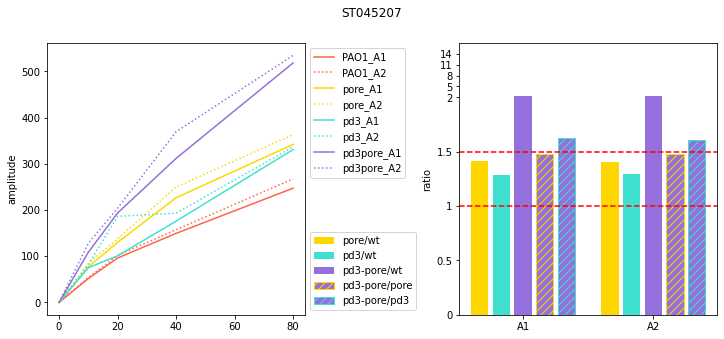

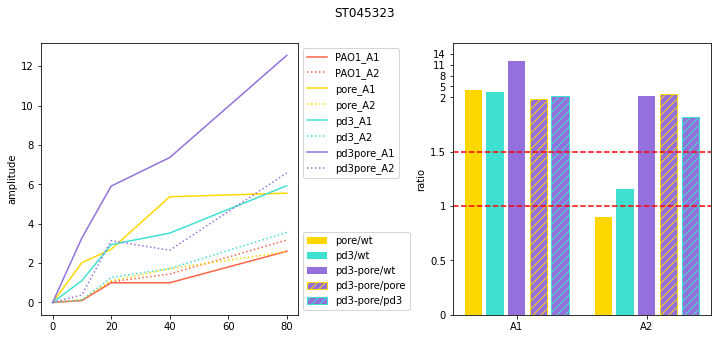

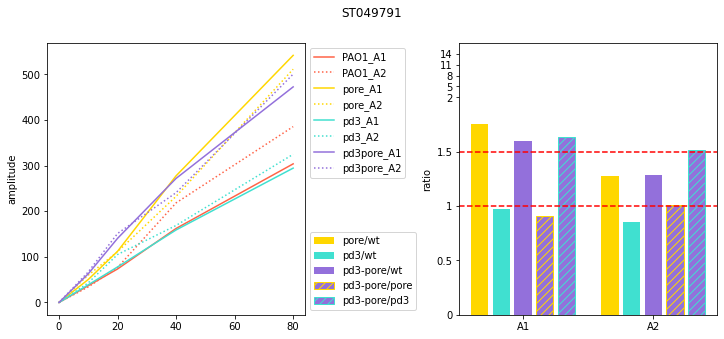

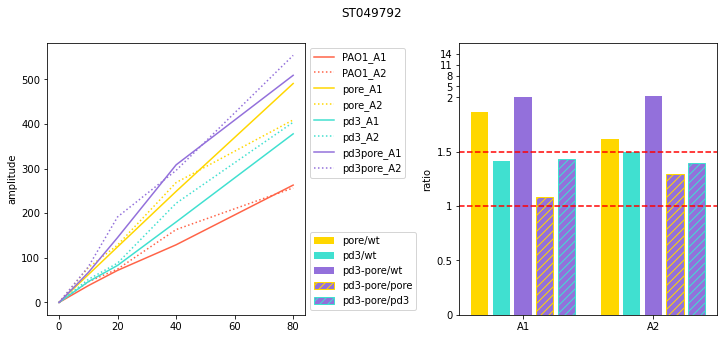

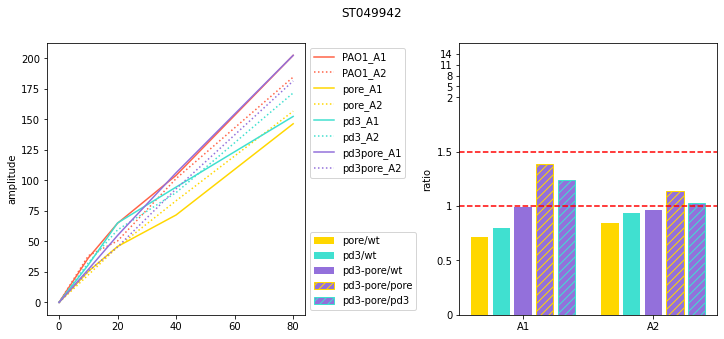

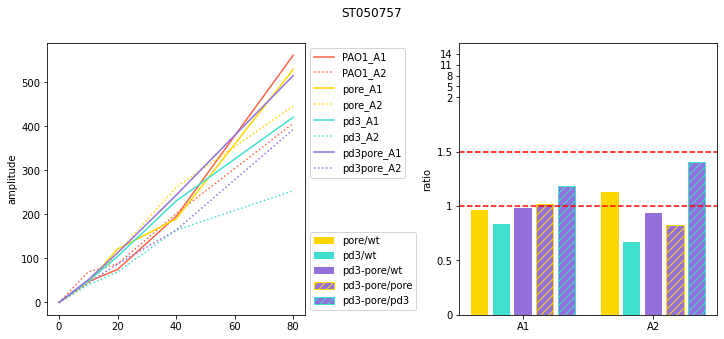

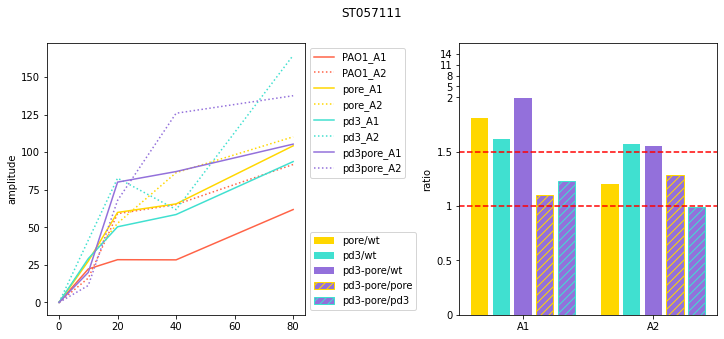

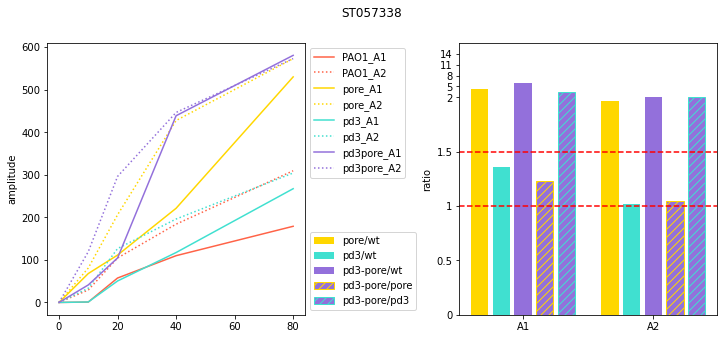

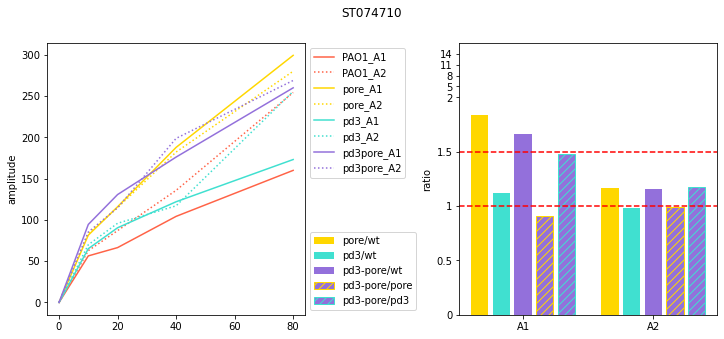

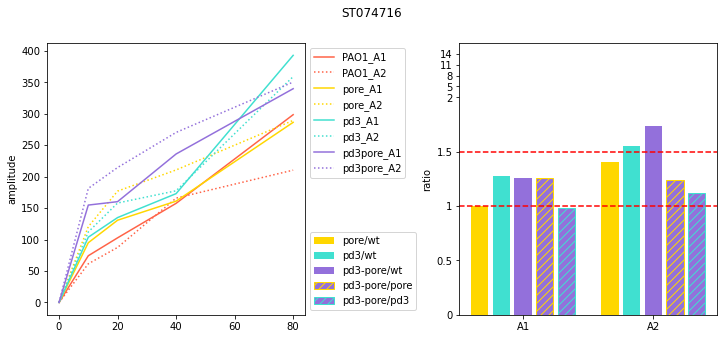

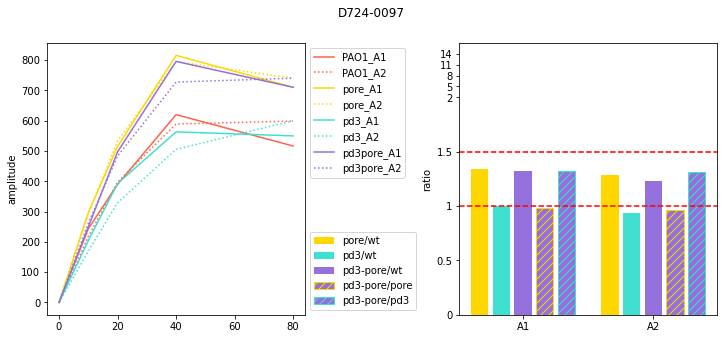

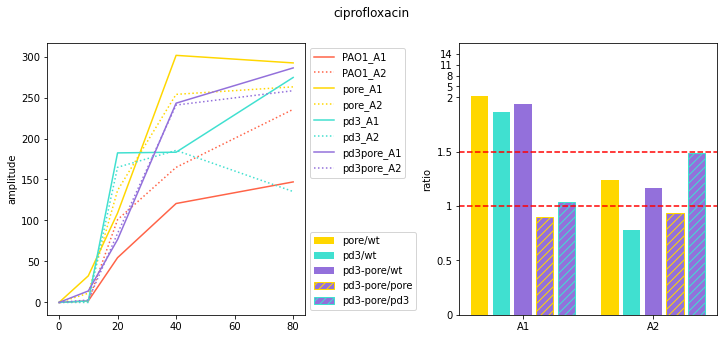

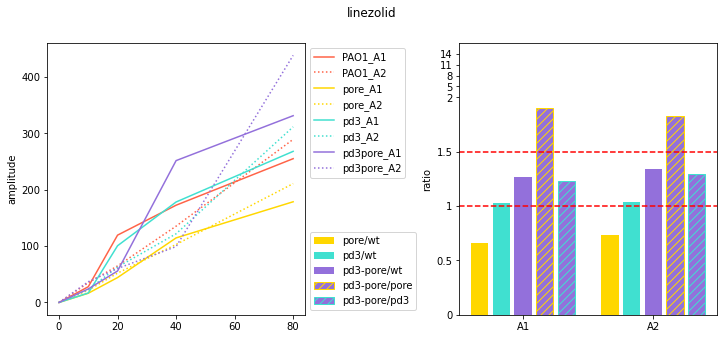

In [8]:
removed_mol = ["ASD007", "ASD012", "ASD019", "ASD021", "D372-0163"]
yy_label = ["PAO1_A1", "PAO1_A2", "pore_A1", "pore_A2", "pd3_A1", "pd3_A2", "pd3pore_A1", "pd3pore_A2"]
curve_color = ["tomato", "tomato", "gold", "gold", "turquoise", "turquoise", "mediumpurple", "mediumpurple"]
line_style = ['-', ":", '-', ":", '-', ":", '-', ":"]
slope_result = [] # slope and r2 of every amplitude curve
ratio_result = [] # ratio of slopes

for row, mol in zip(df_array, molnames):
    # --- uptake curves ---
    Y1 = row[:5] # PAO1_A1
    Y2 = row[5:10] # PAO1_A2
    Yp1 = row[10:15] # pore_A1
    Yp2 = row[15:20] # pore_A2
    Yd1 = row[20:25] # pd3_A1
    Yd2 = row[25:30] # pd3_A2
    Ydp1 = row[30:35] # pd3pore_A1
    Ydp2 = row[35:] # pd3pore_A2
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    plt.subplots_adjust(wspace=0.6)
    if mol in removed_mol:
        fig.suptitle(mol, color="red") # removed molecules are red
    else:
        fig.suptitle(mol)
    ListofY = [Y1, Y2, Yp1, Yp2, Yd1, Yd2, Ydp1, Ydp2]
    ListofSlope = [] # a row of slope_result
    for i in range(8):
        X = np.array([5,10,20,40,80]) # initialize X in every loop
        Y = ListofY[i]
        xx = X[~np.isnan(Y)]
        yy = Y[~np.isnan(Y)]
        ax[0].plot(np.insert(xx, 0, 0), np.insert(yy, 0, 0), color=curve_color[i], linestyle=line_style[i], label=yy_label[i])
        if len(yy) > 0:
            slope, r2 = CalcSlope(X, Y) # fit curve, get slope
            ListofSlope.append(slope)
        else:
            ListofSlope.append(np.nan)

    slope_result.append(ListofSlope) # save slopes

    ax[0].set_ylabel("amplitude")
    ax[0].legend(bbox_to_anchor=(1, 1), loc="upper left")
    
    # --- slope ratios bar plot ---
    bar_labels = ["A1", "A2"]
    
    pw = [scale(ListofSlope[2]/ListofSlope[0]), scale(ListofSlope[3]/ListofSlope[1])]
    dw = [scale(ListofSlope[4]/ListofSlope[0]), scale(ListofSlope[5]/ListofSlope[1])]
    dpw = [scale(ListofSlope[6]/ListofSlope[0]), scale(ListofSlope[7]/ListofSlope[1])]
    dpp = [scale(ListofSlope[6]/ListofSlope[2]), scale(ListofSlope[7]/ListofSlope[3])]
    dpd = [scale(ListofSlope[6]/ListofSlope[4]), scale(ListofSlope[7]/ListofSlope[5])]
    
    ratio_result.append(np.vstack((pw,dw,dpw,dpp,dpd)).flatten('F')) # save ratios

    ax[1].bar([0, 6], pw, label="pore/wt", color="gold")
    ax[1].bar([1, 7], dw, label="pd3/wt", color="turquoise")
    ax[1].bar([2, 8], dpw, label="pd3-pore/wt", color="mediumpurple")
    ax[1].bar([3, 9], dpp, label="pd3-pore/pore", color="mediumpurple", edgecolor='gold', hatch='///')
    ax[1].bar([4, 10], dpd, label="pd3-pore/pd3", color="mediumpurple", edgecolor='turquoise', hatch='///')
    ax[1].axhline(y=1, color='r', linestyle='--')
    ax[1].axhline(y=1.5, color='r', linestyle='--')
    ax[1].set_yticks([0,0.5,1,1.5,2,2.1,2.2,2.3,2.4])
    ax[1].set_ylim(0,2.5)
    ax[1].set_yticklabels(["0","0.5","1","1.5","2","5","8","11","14"])

    ax[1].set_xticks([2, 8])
    ax[1].set_xticklabels(bar_labels)
    ax[1].set_ylabel("ratio")
    ax[1].legend(bbox_to_anchor=(-0.6, 0), loc="lower left")

    plt.show()
    #break

In [13]:
slope_df = pd.DataFrame(slope_result, columns=yy_label)

ratio_header = ["A1_pore/wt","A1_pd3/wt","A1_pd3-pore/wt","A1_pd3-pore/pore","A1_pd3-pore/pd3","A2_pore/wt","A2_pd3/wt","A2_pd3-pore/wt","A2_pd3-pore/pore","A2_pd3-pore/pd3"]

ratio_df = pd.DataFrame(ratio_result, columns=ratio_header)

In [14]:
from sklearn.linear_model import LinearRegression
X1 = np.array([5,10,20,40,80])
print("molecule", "slope", "r2")

for row, mol in zip(df_array, molnames):
    Y1 = row[1:6] # A1
    X = X1[~np.isnan(Y1)]
    Y = Y1[~np.isnan(Y1)]
    X = X.reshape(-1,1)
    reg = LinearRegression(fit_intercept=False).fit(X, Y)
    print(mol, np.round(reg.coef_[0],3), np.round(reg.score(X,Y),3))

molecule slope r2
1500272 0.876 0.877
1501007 1.153 0.993
1501150 2.931 0.517
1503100 10.335 0.993
1503243 8.064 0.996
1504185 3.592 0.894
1505604 11.139 0.938
1505622 24.683 0.995
1506043 3.925 0.938
2300173 3.803 0.867
2300307 7.757 0.761
ASD001 8.919 0.995
ASD002 20.94 0.998
ASD004 10.838 0.993
ASD007 34.241 0.973
ASD012 3.581 0.86
ASD019 2.302 0.973
ASD021 30.663 0.996
D300-0069 4.726 0.985
D300-0109 10.259 0.889
D372-0004 4.086 0.916
D372-0005 8.349 0.988
D372-0044 3.463 0.842
D372-0163 2.611 -4.583
D389-0855 3.938 0.994
D389-0970 6.189 0.883
DP-0000267 1.953 0.981
DP-0000268 1.461 0.994
DP-0000271 1.413 0.983
DP-0000273 0.2 0.916
DP-0000274 2.441 0.984
DP-0000275 3.198 0.994
DP-0000352 4.586 0.748
DP-0000375 2.685 0.975
DP-0000481 0.06 0.999
DP-0000485 1.503 0.953
DP-0000490 1.025 0.959
DP-0000492 0.582 0.84
DP-0000498 1.044 0.935
DP-0000499 0.634 0.974
DP-0000548 5.837 0.999
DP-0000551 5.782 0.951
DP-0000552 4.156 0.98
DP-0000553 0.968 0.99
DP-0000555 3.491 0.914
DP-0000556 1.81